<a href="https://www.kaggle.com/code/sleepymi/garbage-classification-with-resnet50?scriptVersionId=230812334" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Loading Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import copy

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
from PIL import Image

## Settings 

In [2]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Loading Dataset

In [3]:
base_path = "/kaggle/input/garbage-classification-v2/garbage-dataset/"
weights_path = "/kaggle/input/resnet50-weights/resnet50-0676ba61.pth"
class_names = ['metal', 'glass', 'biological', 'paper', 'battery', 
               'trash', 'cardboard', 'shoes', 'clothes', 'plastic']

# Print dataset information
print("Dataset classes:", class_names)
for cls in class_names:
    class_path = os.path.join(base_path, cls)
    if os.path.exists(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{cls}: {num_images} images")

Dataset classes: ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']
metal: 1020 images
glass: 3061 images
biological: 997 images
paper: 1680 images
battery: 944 images
trash: 947 images
cardboard: 1825 images
shoes: 1977 images
clothes: 5327 images
plastic: 1984 images


## Data Transformations

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Create a custom dataset class for loading the garbage images

In [6]:
class GarbageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = class_names
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = self._make_dataset()
        
    def _make_dataset(self):
        samples = []
        for target_class in self.classes:
            class_dir = os.path.join(self.root_dir, target_class)
            if not os.path.isdir(class_dir):
                continue
                
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    path = os.path.join(class_dir, img_name)
                    item = (path, self.class_to_idx[target_class])
                    samples.append(item)
                    
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        try:
            with open(path, 'rb') as f:
                img = Image.open(f).convert('RGB')
            
            if self.transform is not None:
                img = self.transform(img)
                
            return img, target
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            # Return a placeholder image and the target
            placeholder = torch.zeros(3, 224, 224)
            return placeholder, target

## Load the full dataset

In [7]:
print("Loading dataset...")
full_dataset = GarbageDataset(base_path, transform=data_transforms['val'])
print(f"Total images: {len(full_dataset)}")

# Split into train and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply different transforms to train and validation
train_dataset.dataset = GarbageDataset(base_path, transform=data_transforms['train'])
val_dataset.dataset = GarbageDataset(base_path, transform=data_transforms['val'])

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Create a dictionary of datasets and dataloaders for easier access
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")

Loading dataset...
Total images: 19762
Training samples: 15809
Validation samples: 3953


## Visualize some images

Sample training images:


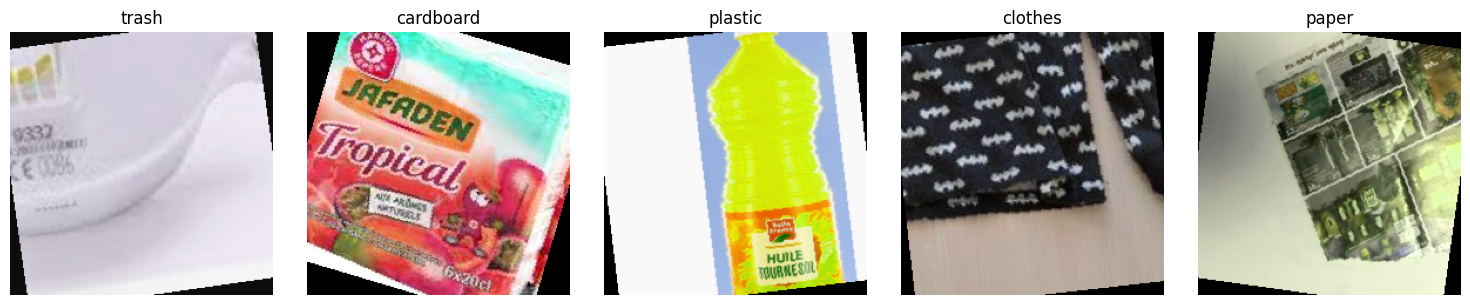

In [8]:
def show_samples(dataloader, num_samples=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        # Convert tensor to numpy and denormalize
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Sample training images:")
show_samples(train_loader)

## Defining Model

In [9]:
def initialize_model(num_classes, weights_path):
    # Using ResNet50 pre-trained on ImageNet
    model = models.resnet50()
    state_dict = torch.load(weights_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    
    # Freeze all parameters first for faster training
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    
    return model

# Initialize the model
print("Initializing model...")
num_classes = len(class_names)
model = initialize_model(num_classes, weights_path)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Initializing model...


## Training Model

In [10]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Store training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data with progress bar
            loop = tqdm(dataloaders[phase], desc=phase)
            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                loop.set_postfix(loss=loss.item())
            
            if phase == 'train' and scheduler is not None:
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Train the model
print("Training the model...")
model, history = train_model(
    model, 
    dataloaders, 
    criterion, 
    optimizer, 
    scheduler,
    num_epochs=10  # Reduced for faster execution in Kaggle
)

Training the model...
Epoch 1/10
----------


train:   0%|          | 0/495 [00:00<?, ?it/s]

train Loss: 0.9665 Acc: 0.6810


val:   0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4429 Acc: 0.8492

Epoch 2/10
----------


train:   0%|          | 0/495 [00:00<?, ?it/s]

train Loss: 0.7609 Acc: 0.7477


val:   0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.3908 Acc: 0.8700

Epoch 3/10
----------


train:   0%|          | 0/495 [00:00<?, ?it/s]

train Loss: 0.7408 Acc: 0.7572


val:   0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.3678 Acc: 0.8796

Epoch 4/10
----------


train:   0%|          | 0/495 [00:00<?, ?it/s]

train Loss: 0.7152 Acc: 0.7591


val:   0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.3437 Acc: 0.8882

Epoch 5/10
----------


train:   0%|          | 0/495 [00:00<?, ?it/s]

train Loss: 0.6906 Acc: 0.7679


val:   0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.3341 Acc: 0.8932

Epoch 6/10
----------


train:   0%|          | 0/495 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.7721


val:   0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.3097 Acc: 0.8983

Epoch 7/10
----------


train:   0%|          | 0/495 [00:00<?, ?it/s]

train Loss: 0.6710 Acc: 0.7756


val:   0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.3399 Acc: 0.8867

Epoch 8/10
----------


train:   0%|          | 0/495 [00:00<?, ?it/s]

train Loss: 0.6057 Acc: 0.8032


val:   0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.3067 Acc: 0.9024

Epoch 9/10
----------


train:   0%|          | 0/495 [00:00<?, ?it/s]

train Loss: 0.5888 Acc: 0.8072


val:   0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.3071 Acc: 0.9039

Epoch 10/10
----------


train:   0%|          | 0/495 [00:00<?, ?it/s]

train Loss: 0.5866 Acc: 0.8100


val:   0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.3009 Acc: 0.9026

Training complete in 19m 53s
Best val Acc: 0.9039


## Function to plot training history

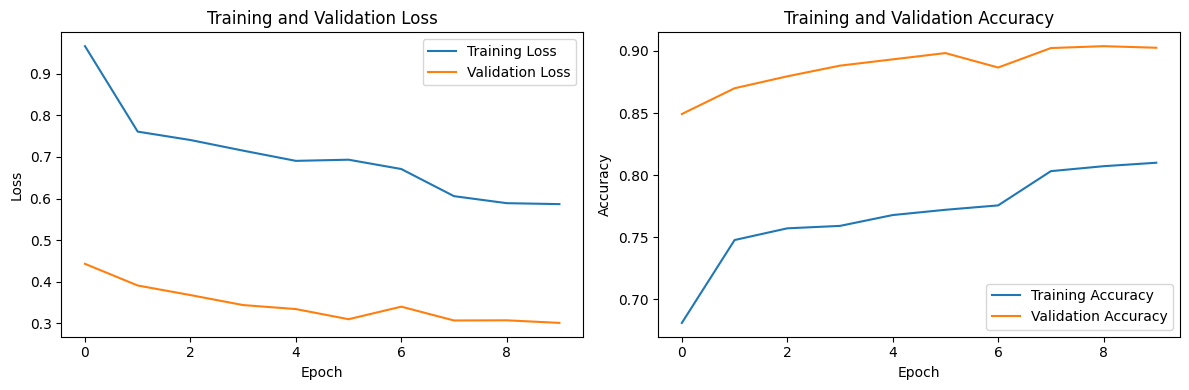

In [17]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_history.png')
    plt.show()

plot_training_history(history)

## Visualize model predictions

Visualizing model predictions...


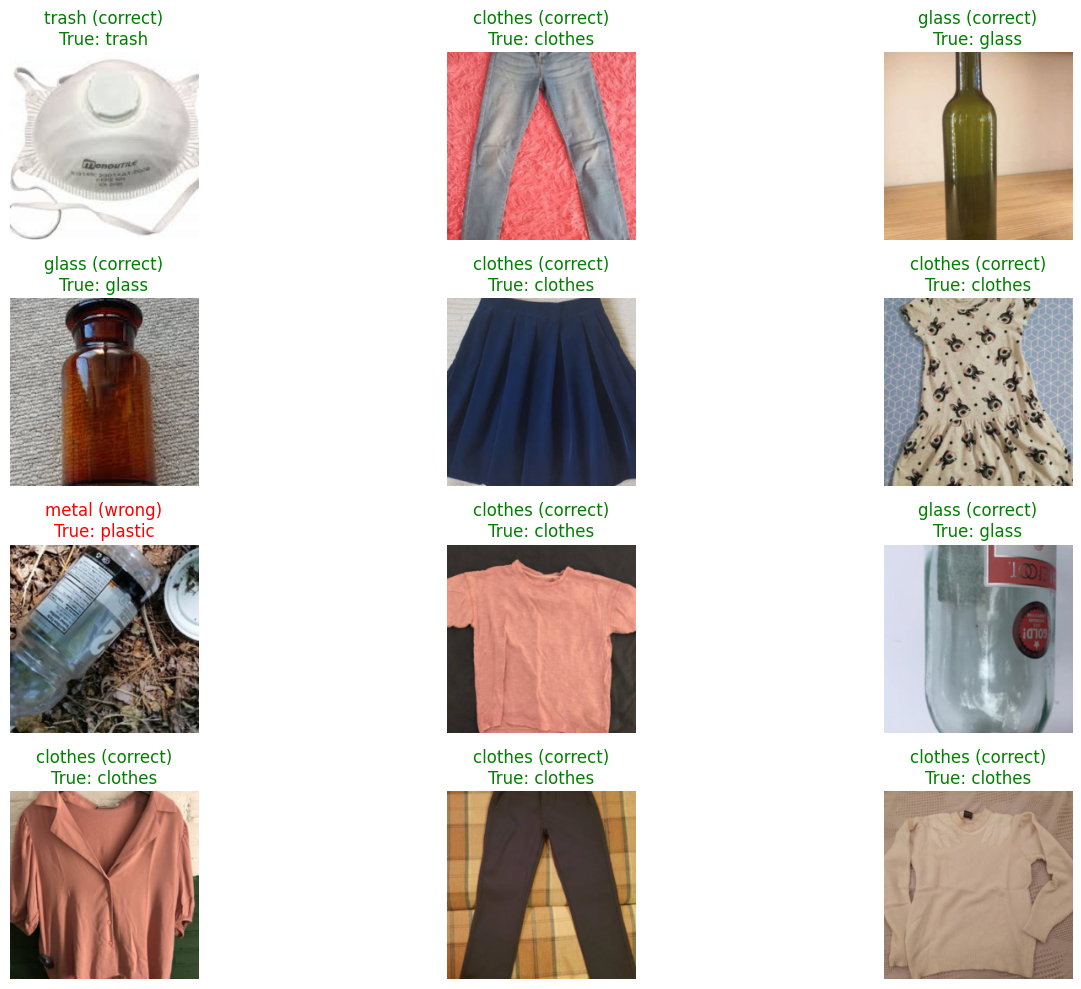

In [18]:
def visualize_model_predictions(model, dataloader, class_names, num_images=12):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                
                # Display if prediction is correct
                is_correct = 'correct' if preds[j] == labels[j] else 'wrong'
                title = f"{class_names[preds[j]]} ({is_correct})\nTrue: {class_names[labels[j]]}"
                ax.set_title(title, color='green' if is_correct == 'correct' else 'red')
                
                # Convert tensor to numpy and denormalize
                img = inputs.cpu()[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
                
                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.savefig('/kaggle/working/model_predictions.png')
                    return
    plt.tight_layout()
    plt.savefig('/kaggle/working/model_predictions.png')
    plt.show()

print("Visualizing model predictions...")
visualize_model_predictions(model, val_loader, class_names)

## Confusion Matrix

Creating confusion matrix...


Evaluating:   0%|          | 0/124 [00:00<?, ?it/s]

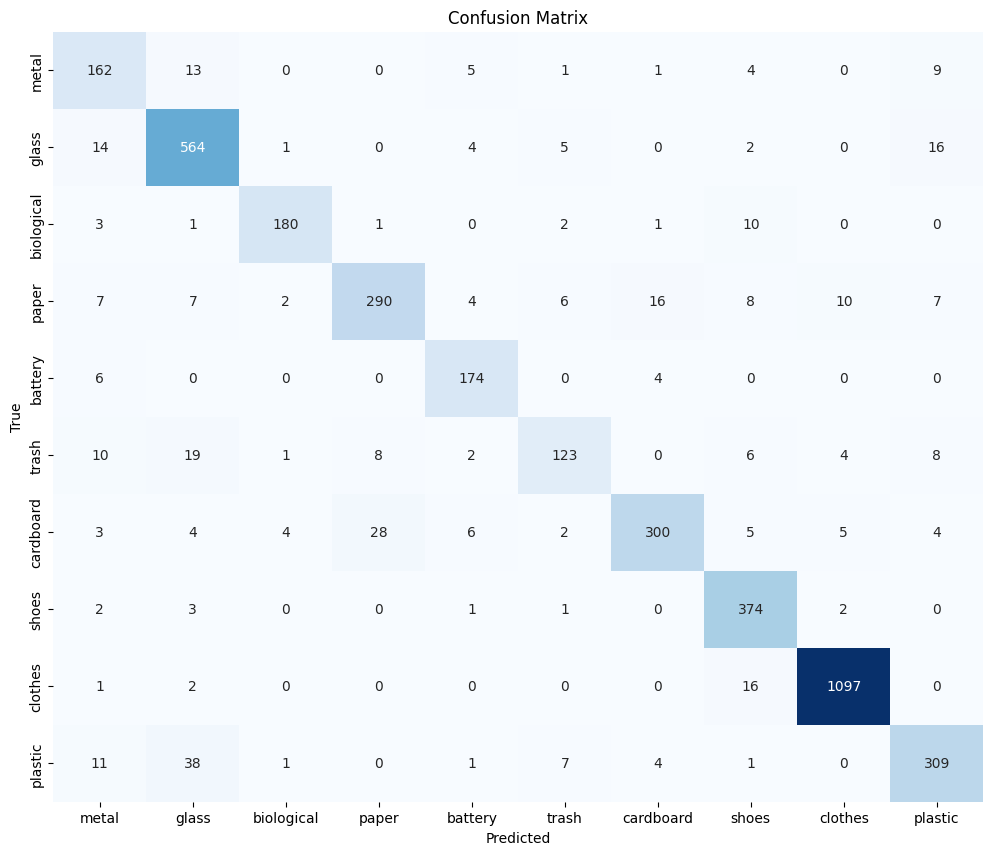

Overall Accuracy: 0.9039
metal Accuracy: 0.8308
glass Accuracy: 0.9307
biological Accuracy: 0.9091
paper Accuracy: 0.8123
battery Accuracy: 0.9457
trash Accuracy: 0.6796
cardboard Accuracy: 0.8310
shoes Accuracy: 0.9765
clothes Accuracy: 0.9830
plastic Accuracy: 0.8306
Model saved to /kaggle/working/garbage_classification_model.pth


In [19]:
def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.numpy())
    
    # Create confusion matrix
    cm = pd.DataFrame(
        data=np.zeros((len(class_names), len(class_names)), dtype=np.int32),
        index=class_names,
        columns=class_names
    )
    
    # Fill the confusion matrix
    for i in range(len(y_true)):
        cm.iloc[y_true[i], y_pred[i]] += 1
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('/kaggle/working/confusion_matrix.png')
    plt.show()
    
    # Calculate accuracy
    accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # Calculate per-class accuracy
    for i, class_name in enumerate(class_names):
        class_idx = np.where(np.array(y_true) == i)[0]
        if len(class_idx) > 0:
            class_acc = np.sum(np.array(y_pred)[class_idx] == i) / len(class_idx)
            print(f"{class_name} Accuracy: {class_acc:.4f}")

print("Creating confusion matrix...")
plot_confusion_matrix(model, val_loader)

# Save the trained model to Kaggle output directory
output_path = "/kaggle/working/garbage_classification_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': class_names,
    'epoch': 10
}, output_path)
print(f"Model saved to {output_path}")

## Function for making predictions on new images

In [1]:
def predict_single_image(model, image_path, class_names):
    # Load and preprocess image
    transform = data_transforms['val']
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0]
    
    # Get top 3 predictions
    top3_prob, top3_catid = torch.topk(probs, 3)
    
    # Display image with predictions
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {class_names[preds[0]]}')
    
    # Create text for top 3 predictions
    prediction_text = "\n".join([
        f"{class_names[top3_catid[i]]}: {100 * top3_prob[i].item():.2f}%"
        for i in range(3)
    ])
    plt.figtext(0.15, 0.05, prediction_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.show()
    
    return class_names[preds[0]], probs.cpu().numpy()

# Example of how to use the prediction function (if you have test images)
# predict_single_image(model, "/kaggle/input/garbage-classification-v2/test_image.jpg", class_names)
